Mount το google drive. Το κάνουμε αυτό για έχουμε πρόσβαση στα python modules που χρειαζόμαστε.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Το συνδέουμε με το folder του συγκεκριμένου εργαστηρίου

In [5]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Lab_DL_ex1')

Εγκαθιστούμε τις απαραίτητες βιβλιοθήκες

In [ ]:
import sys

!{sys.executable} -m pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0

In [ ]:
!{sys.executable} -m pip install matplotlip

### Οδηγίες

Σε αυτή την εργασία θα κάνετε τα εξής:
1. Δοκιμή τουλάχιστον των 3 καλύτερων συνδυασμών των παραμέτρων width και depth του Δικτύου wideResNet σύμφωνα με αυτά που προτείνονται και στο paper (results with moderate data augmentation)

2. Regularization. Το δίκτυο έχει μηχανισμό ομαλοποίησης (Dropout). Δοκιμάστε να προσθέσετε το Dropout (παράμετρος droprate) όπως αναφέρει το paper και καταγράψτε τα αποτελέσματα για τα παραπάνω μοντέλα.

3. Κρατώντας τις παραμέτρους του δικτύου με τα καλύτερα αποτελέσματα (load best model από το 1 και 2) θα κάνετε test στο CIFAR-C. Έπειτα, θα εφαρμόσετε τη μέθοδο mixup (συμπληρώστε τον κώδικα στο κελί με το CifarDataset) κάντε εκ νέου την εκπαίδευση και καταγράψτε τα αποτελέσματα.

4. (Bonus) Κάντε επίσης ένα plot των confidence scores (softmax predictions) και συγκρίνετε το με το αντίστοιχο plot όταν το μοντέλο δεν είχε mixup. Τι παρατηρείτε?

Tip: Για το κάθε πείραμα (training) μην το τρέξετε πάνω από 20 εποχές


Ορισμένα κελιά κώδικα παρέχονται για εσάς σε αυτό το notebook. Θα πρέπει να αποφύγετε την επεξεργασία του παρεχόμενου κώδικα και να φροντίσετε να εκτελέσετε τα κελιά για να αποφύγετε απροσδόκητα σφάλματα. Ορισμένα κελιά ξεκινούν με τη γραμμή:

΄#### GRADED CELL ####`
Αυτά θα βαθμολογηθούν. Φρόντιστε για κάθε κελί να δικαιολογείτε με σχόλια τις επιλογές σας.


### Ας ξεκινήσουμε!

Θα ξεκινήσουμε την εκτέλεση ορισμένων imports και τη φόρτωση του συνόλου δεδομένων. Μην επεξεργαστείτε τα υπάρχοντα imports στο παρακάτω κελί. Εάν θέλετε να κάνετε περαιτέρω imports, θα πρέπει να τα προσθέσετε εδώ.

Φορτώνουμε τις απαραίτητες βιβλιοθήκες

In [ ]:
import numpy as np
import time
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from wideresnet import WideResNet
import logging
import shutil
import os
import matplotlib.pyplot as plt



torch.manual_seed(0)
np.random.seed(0)


In [ ]:
data_dir = "/content/drive/My Drive/Lab_DL_ex1/data"




Δημιουργία φακέλου στο οποίο θα κρατάμε τα log files των πειραμάτων

In [ ]:
exp_name = "/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log"


exp_dir = os.path.join('Cifar', exp_name)

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)


logfile = open(os.path.join(exp_dir, 'log'), 'w')

Στο παρακάτω κελί θα δημιουργήσουμε το train και validation loader χρησιμοποιώντας τη συνάρτηση construct_datasets

In [ ]:
def construct_datasets(data_dir, batch_size):
    def data2loader_train(tr_data):
        train_loader = torch.utils.data.DataLoader(
            tr_data,
            batch_size=batch_size,
            shuffle=True)
        return train_loader

    def data2loader_test(te_data):
        test_loader = torch.utils.data.DataLoader(
            te_data,
            batch_size=batch_size,
            shuffle=False)

        return test_loader

    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(), normalize])

    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])

    train_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=False, transform=test_transform, download=True)
    print("Train set number of items ", len(train_data))
    print("Val set number of items ", len(test_data))

    return data2loader_train(train_data), data2loader_test(test_data)

In [ ]:
batch_size = 128
train_loader, val_loader = construct_datasets(data_dir, batch_size)

Files already downloaded and verified
Files already downloaded and verified
Train set number of items  50000
Val set number of items  10000


Σε αυτό το σημείο θα ορίσουμε το μοντέλο (Wide Residual Network), τη loss function και τον scheduler αυτής και τον optimizer

In [ ]:
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            targets = targets.cuda(non_blocking=True).long()
            images = images.cuda(non_blocking=True).float()
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))



In [ ]:

def train_model(num_iters, train_loader, model):

  # Train loop

  for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()

    params = list(model.parameters())
    output = model(input)
    ce_loss = criterion(output, target)
    #ce_loss = criterion(output, target)


    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    scheduler.step()


      # measure accuracy and record loss
    prec1 = accuracy(output, target, topk=(1,))[0]
    losses.update(ce_loss.data.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))



    if t % print_freq == 0 and t >= print_freq:

        loss1, prec1 = test_cifar(val_loader, model)
        #print("Epoch ", epoch)
        print("Validation set acc", prec1)
        logfile.write('validation set acc: ' + str(prec1) + '\n')
        #print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))




  # validate_all(model, args.data_dir, exp_name, args.batch_size, logfile, t, kwargs)

  print('Cifar accuracy {}'.format(test_cifar(val_loader, model)))
  logging.info(f'avg acc {test_cifar(val_loader, model)}')
  logfile.write(str(t) + ' Val acc: ' + str(test_cifar(val_loader, model)) + '\n')
  #logfile.close()





Ζητούμενο 1 και 2.

Στο παρακάτω κελί φαίνεται ένα παράδειγμα ενός wide residual network.
Διαβάζοντας το paper θα πρέπει να βρείτε τις παραμέτρους για τα 3 καλύτερα μοντέλα που προτείνονται στο paper.

Χρησιμοποιείστε το παρακάτω κελί ως template και σχολιάστε τις επιλογές σας σε markdown κελί κάνοντας αναφορά στο paper.

In [ ]:
# Model Parameters cell

num_epochs = 5

print_freq = 391 # evaluation frequency (and log) (every epoch)

num_iters = print_freq * num_epochs  # number of total epochs to run

batch_size = 128



In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 1

layers =  28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0.0  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model_1 = WideResNet(layers, num_classes, widen_factor, droprate)


model_1 = model_1.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_1.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model_1)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_1'
# Save the model state dictionary
torch.save(model_1.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_1


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 2

layers = 16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate =  0.0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model_2 = WideResNet(layers, num_classes, widen_factor, droprate)


model_2 = model_2.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_2.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

train_model(num_iters, train_loader, model_2)

Validation set acc 0.61
Validation set acc 0.7185
Validation set acc 0.8173
Validation set acc 0.8482
Cifar accuracy (0.003095915122330189, 0.866)


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_2'
# Save the model state dictionary
torch.save(model_2.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_2


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 3

layers = 40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate =  0.0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model_3 = WideResNet(layers, num_classes, widen_factor, droprate)


model_3 = model_3.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_3.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model_3)

Validation set acc 0.6283
Validation set acc 0.6892
Validation set acc 0.7805
Validation set acc 0.8516
Cifar accuracy (0.0030871217653155327, 0.8678)


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_3'
# Save the model state dictionary
torch.save(model_3.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_3


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 1 with dropout

layers =  28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0.3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model_11 = WideResNet(layers, num_classes, widen_factor, droprate)


model_11 = model_11.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_11.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model_11)

Validation set acc 0.5375
Validation set acc 0.7186
Validation set acc 0.7748
Validation set acc 0.8415
Cifar accuracy (0.0033557118147611617, 0.8587)


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_11'
# Save the model state dictionary
torch.save(model_11.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_11


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 2 with dropout

layers = 16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate =  0.3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model_22 = WideResNet(layers, num_classes, widen_factor, droprate)


model_22 = model_22.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_22.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

train_model(num_iters, train_loader, model_22)

Validation set acc 0.5933
Validation set acc 0.7044
Validation set acc 0.7899
Validation set acc 0.8318
Cifar accuracy (0.0035847185403108596, 0.8448)


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_22'
# Save the model state dictionary
torch.save(model_22.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_22


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 3 with dropout

layers = 40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate =  0.3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model_33 = WideResNet(layers, num_classes, widen_factor, droprate)


model_33 = model_33.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model_33.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model_33)

Validation set acc 0.5478
Validation set acc 0.6606
Validation set acc 0.7645
Validation set acc 0.8152
Cifar accuracy (0.0038127711832523347, 0.8363)


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_33'
# Save the model state dictionary
torch.save(model_33.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_33


# Μέρος 3
## WRN με MIxup augmentation στο CIFAR-C


Στις περισσότερες επιτυχημένες εφαρμογές τα νευρωνικά δίκτυα (large deep neuaral networks) μοιράζονται δύο κοινά σημεία. Πρώτον, είναι
εκπαιδευμένοι ώστε να ελαχιστοποιούν το μέσο σφάλμα τους στα δεδομένα εκπαίδευσης, ένας κανόνας εκμάθησης γνωστός και Empirical Risk Minimazation (ERM) (Vapnik, 1998). Δεύτερον, το μέγεθος αυτών των νευρωνικών δικτύων  κλιμακώνεται γραμμικά με τον αριθμό των παραδειγμάτων εκπαίδευσης.

Παραδόξως, ένα κλασικό αποτέλεσμα στη θεωρία μάθησης (Vapnik & Chervonenkis, 1971) μας λέει ότι η
η σύγκλιση του ERM είναι εγγυημένη εφόσον το μέγεθος της μηχανής εκμάθησης (π.χ.
δίκτυο) δεν αυξάνεται με τον αριθμό των δεδομένων εκπαίδευσης. Εδώ, το μέγεθος μιας μηχανής εκμάθησης μετριέται ως προς τον αριθμό των παραμέτρων το.

Αυτή η αντίφαση αμφισβητεί την καταλληλότητα του ERM να εκπαιδεύει τα τρέχοντα μοντέλα νευρωνικών δικτύων μας. Από τη μία πλευρά, ο ERM επιτρέπει σε μεγάλα νευρωνικά δίκτυα να απομνημονεύουν
(αντί να γενικεύσουμε από) τα δεδομένα εκπαίδευσης ακόμη και με την παρουσία ισχυρής ομαλοποίησης (Dropout). Επίσης, α νευρωνικά δίκτυα που έχουν εκπαιδευτεί με ERM αλλάζουν δραστικά τις προβλέψεις τους όταν αξιολογούνται
παραδείγματα με μικρές διαφορές από την κατανομή της εκπαίδευσης (adversarial examples). Αυτά τα στοιχεία υποδηλώνουν ότι ο ERM δεν είναι σε θέση να εξηγήσει ή να παράσχει γενίκευση στις δοκιμές κατανομές που διαφέρουν ελάχιστα από τα δεδομένα εκπαίδευσης. Ωστόσο, ποια είναι η εναλλακτική του ERM;

Η μέθοδος επιλογής για εκπαίδευση σε παρόμοια αλλά διαφορετικά παραδείγματα με τα δεδομένα εκπαίδευσης είναι γνωστή ως δεδομένα επάυξησης (Data augmentation) (Simard et al., 1998), Vicinal Risk Minimization (VRM)
(Chapelle et al., 2000). Στο VRM, απαιτείται ανθρώπινη γνώση για να περιγράψει μια γειτονιά γύρω από κάθε παράδειγμα στα δεδομένα εκπαίδευσης. Στη συνέχεια, μπορούν να αντληθούν πρόσθετα εικονικά παραδείγματα από το
διανομή των παραδειγμάτων εκπαίδευσης σε κοντινή απόσταση για να διευρυνθεί η υποστήριξη της κατανομής εκπαίδευσης. Για παράδειγμα, κατά την εκτέλεση ταξινόμησης εικόνων, είναι σύνηθες να ορίζεται η γειτνίαση μιας εικόνας
ως το σύνολο των οριζόντιων αντανακλάσεων, των ελαφρών περιστροφών. Ενώ η αύξηση δεδομένων οδηγεί σταθερά σε βελτιωμένη γενίκευση, η διαδικασία εξαρτάται από τα δεδομένα, και συνεπώς απαιτεί τη χρήση ειδικών γνώσεων. Επιπλέον, η αύξηση δεδομένων προϋποθέτει ότι τα παραδείγματα στην περιοχή μοιράζονται την ίδια κλάση και δεν μοντελοπιούν τη σχέση γειτνίασης μεταξύ των παραδειγμάτων
διαφορετικών κλάσεων.

Έχοντας αυτά σαν δεδομένα θα δοκιμάσουμε το mixup  ["mixup data augmentation"](https://arxiv.org/pdf/1710.09412.pdf).

Εν συντομία, το mixup κατασκευάζει εικονικά δεδομένα εκπαίδευσης με τον εξής τρόπο:

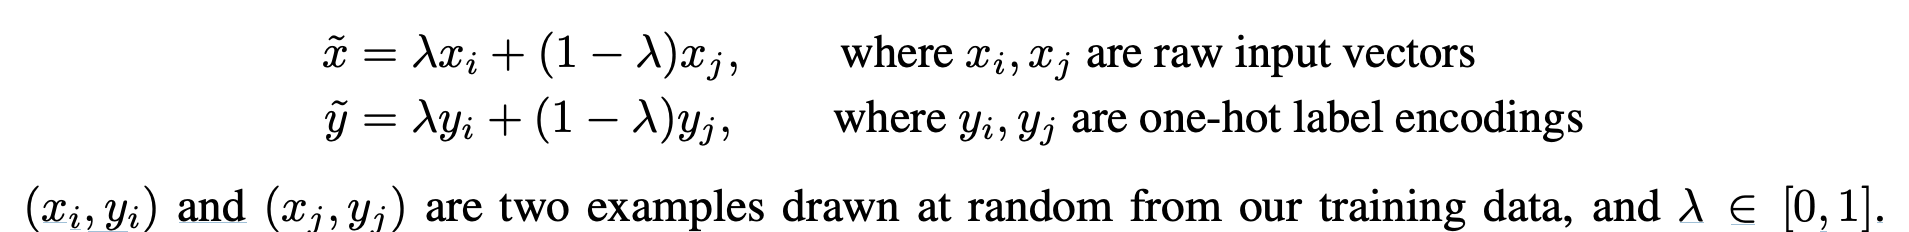

#### Αξιολόγηση του μοντέλου στο CIFAR-C

Για να καταλάβουμε περισσότερο τη χρησιμότητα του mixup και γενικότερα της επαύξησησς της κατανομής των δεδομένων εκπαίδευσης θα εκπαιδεύσουμε πάλι το μοντέλο μας στο CIFAR αλλά θα το κάνουμε evaluate στο CIFAR-C.

ΤοCIFAR-C παριέχει διάφορα corruptions (adversarial examples) στις εικόνες του αρχικού dataset, κάτι που το καθιστά πιο κοντά σε μια ρεαλιστική αξιολόγηση του μοντέλου.

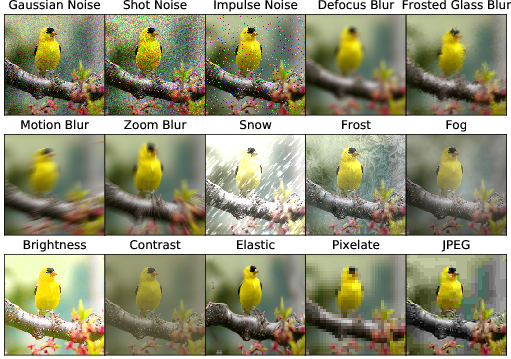


In [ ]:
#### GRADED CELL ####

# Complete the following code and run the cell
from torch.distributions.beta import Beta
from torch.utils.data import Dataset

class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform, mixup):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.mixup = mixup

        print("We called the function")
        print("Mixup variable:",self.mixup)

        # Loading all the data depending on whether the dataset is training or testing
        if self.train:
            print("We called the function for training data")
            print(self.train)
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            print("We called the function for testing data")
            print(self.train)
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format which PyTorch takes in the images
        # Original CIFAR format can be seen via its official page
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # print("We called the getitem")
        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # Transform the image by converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
#  If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and self.mixup and idx % 5 == 0:
            # print("We used mixup here")
            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            mixup_label[self.targets[mixup_idx]] = 1.
            mixup_image = self.transform(self.data[mixup_idx]) if self.transform else self.data[mixup_idx]

            # Select a random number from the given beta distribution
            lam = Beta(torch.tensor([1.0]), torch.tensor([1.0])).sample().item()

            # Mixup the images and labels accordingly
            image = lam * image + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label

        return image, label

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

In [ ]:
# Evaluation scripts


def val_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            #targets = targets.cuda(non_blocking=True).long()
            #images = images.cuda(non_blocking=True).float()
            logits = net(images)
            pred = logits.data.max(1)[1]
            #total_correct += pred.eq(targets.data).sum().item()
            total_correct += int((pred == torch.argmax(targets, dim=1)).float().sum())
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_correct / len(test_loader.dataset)


def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))

In [ ]:
# Utils scripts

def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))


In [ ]:
#### GRADED CELL ####

# Κάντε train το καλύτερο μοντέλο που βρήκατε (και αποθηκεύσατε) στα βήματα 1 και 2

#ΧΩΡΙΣ το mixup
# Hint


num_epochs = 5

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers = 40  # total number of layers of wrn (wide residual network)
num_classes = 10  # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = 0.0  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005



model_without_mixup = WideResNet(layers, num_classes, widen_factor, droprate)

model_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_3'
model_state_dict_1 = torch.load(model_path)

model_without_mixup.load_state_dict(model_state_dict_1)

model = model_without_mixup.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

criterion = nn.CrossEntropyLoss().cuda()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 0, transform, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0
softmax_outputs_without_mixup = []
epoch = 0
for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    softmax_preds = nn.Softmax(dim=1)(preds)
    softmax_outputs_without_mixup.append(softmax_preds.detach())  # Keeps on GPU
    loss = criterion(softmax_preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))
        epoch += 1

We called the function
Mixup variable: False
We called the function for training data
1
We called the function
Mixup variable: False
We called the function for testing data
0
t =  391
Epoch  0
Validation set acc 0.7709
Weather
	 Test Acc 0.446
Blur
	 Test Acc 0.432
Noise
	 Test Acc 0.338
Digital
	 Test Acc 0.494
Average Cifar-C accuracy 0.4277575
t =  782
Epoch  1
Validation set acc 0.7078
Weather
	 Test Acc 0.421
Blur
	 Test Acc 0.357
Noise
	 Test Acc 0.271
Digital
	 Test Acc 0.443
Average Cifar-C accuracy 0.37298208333333327
t =  1173
Epoch  2
Validation set acc 0.7601
Weather
	 Test Acc 0.490
Blur
	 Test Acc 0.476
Noise
	 Test Acc 0.384
Digital
	 Test Acc 0.486
Average Cifar-C accuracy 0.4591712499999999
t =  1564
Epoch  3
Validation set acc 0.746
Weather
	 Test Acc 0.481
Blur
	 Test Acc 0.438
Noise
	 Test Acc 0.399
Digital
	 Test Acc 0.481
Average Cifar-C accuracy 0.4497025


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_without_mixup'
# Save the model state dictionary
torch.save(model_without_mixup.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_without_mixup


In [ ]:
# Save the list of GPU tensors
list_ath = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/softmax_pred_without_mix'
torch.save(softmax_outputs_without_mixup, list_ath)

In [ ]:
#### GRADED CELL ####
# Train your best model with mixup and test on CIFAR-C



# WITH MIXUP





# Model parameters



num_epochs = 5

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers = 40  # total number of layers of wrn (wide residual network)
num_classes = 10  # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = 0.0  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005



model_with_mixup = WideResNet(layers, num_classes, widen_factor, droprate)

model_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_3'
model_state_dict_1 = torch.load(model_path)

model_with_mixup.load_state_dict(model_state_dict_1)

model = model_with_mixup.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

criterion = nn.CrossEntropyLoss().cuda()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Initialize the training dataset with mixup set to True
train_dataset = CIFAR_Dataset(
    data_dir='/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',
    train=True,  # Use boolean True for clarity
    transform=transform,
    mixup=True   # Enable mixup for training
)

# Initialize the validation dataset with mixup set to False
val_dataset = CIFAR_Dataset(
    data_dir='/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',
    train=False,  # Use boolean False for validation dataset
    transform=transform,
    mixup=True   # Disable mixup for validation
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0
softmax_outputs_with_mixup = []
epoch = 0
for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    softmax_preds = nn.Softmax(dim=1)(preds)
    softmax_outputs_with_mixup.append(softmax_preds.detach())  # Keeps on GPU
    loss = criterion(softmax_preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))
        epoch += 1

We called the function
Mixup variable: True
We called the function for training data
True
We called the function
Mixup variable: True
We called the function for testing data
False
t =  391
Epoch  0
Validation set acc 0.7017
Weather
	 Test Acc 0.526
Blur
	 Test Acc 0.448
Noise
	 Test Acc 0.346
Digital
	 Test Acc 0.475
Average Cifar-C accuracy 0.44863791666666664
t =  782
Epoch  1
Validation set acc 0.7394
Weather
	 Test Acc 0.454
Blur
	 Test Acc 0.365
Noise
	 Test Acc 0.230
Digital
	 Test Acc 0.449
Average Cifar-C accuracy 0.37450416666666664
t =  1173
Epoch  2
Validation set acc 0.6975
Weather
	 Test Acc 0.419
Blur
	 Test Acc 0.311
Noise
	 Test Acc 0.288
Digital
	 Test Acc 0.419
Average Cifar-C accuracy 0.3593491666666667
t =  1564
Epoch  3
Validation set acc 0.7609
Weather
	 Test Acc 0.515
Blur
	 Test Acc 0.393
Noise
	 Test Acc 0.283
Digital
	 Test Acc 0.505
Average Cifar-C accuracy 0.42399374999999995


In [ ]:
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_with_mixup'
# Save the model state dictionary
torch.save(model_with_mixup.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/model_with_mixup


In [ ]:
# Save the list of GPU tensors
list_ath = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/softmax_pred_with_mix'
torch.save(softmax_outputs_with_mixup, list_ath)

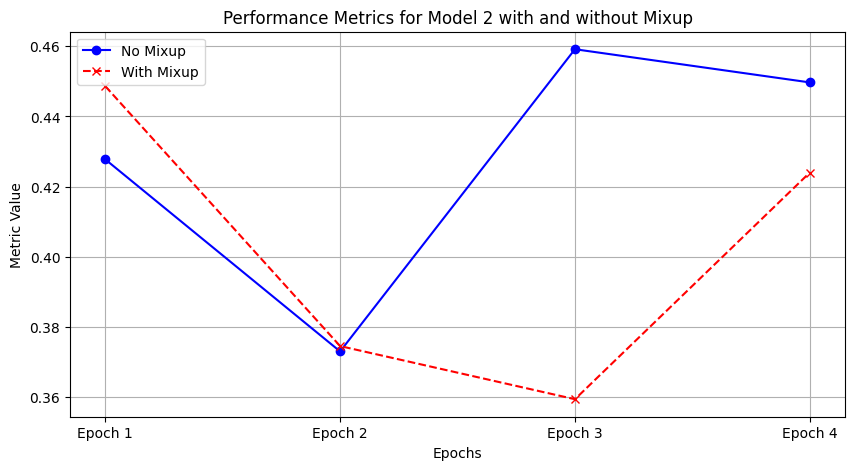

In [ ]:
#### GRADED CELL #### (Bonus)

# Plot the confidence scores for CIFAR-C with WRN model
# trained with and without mixup and comment
import matplotlib.pyplot as plt

# Data for model_2 with and without mixup
model_without_mixup_1 = [0.4277575,0.37298208333333327,0.4591712499999999,0.4497025]
model_with_mixup_1 = [0.44863791666666664,0.37450416666666664,0.3593491666666667,0.42399374999999995]

# Plotting both datasets
plt.figure(figsize=(10, 5))
plt.plot(model_without_mixup_1, marker='o', linestyle='-', color='b', label='No Mixup')
plt.plot(model_with_mixup_1, marker='x', linestyle='--', color='r', label='With Mixup')
plt.title('Performance Metrics for Model 2 with and without Mixup')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.xticks(range(len(model_without_mixup_1)), labels=[f'Epoch {i+1}' for i in range(len(model_without_mixup_1))])
plt.grid(True)
plt.legend()
plt.show()


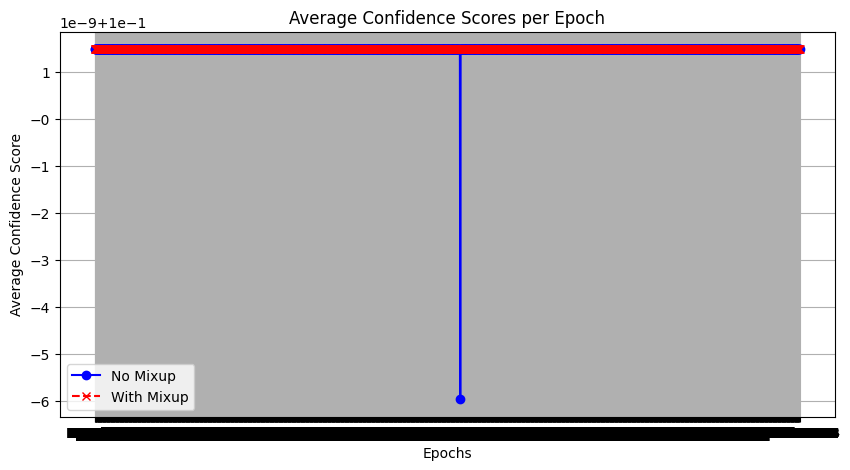

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming softmax_outputs_without_mixup and softmax_outputs_with_mixup are lists of tensors
# Convert and flatten tensors to CPU and then to NumPy for plotting
softmax_outputs_without_mixup_np = [output.cpu().numpy().flatten() for output in softmax_outputs_without_mixup]
softmax_outputs_with_mixup_np = [output.cpu().numpy().flatten() for output in softmax_outputs_with_mixup]

# If the outputs are from multiple epochs and you want to plot average scores per epoch
# Calculate the average of outputs for each epoch (assuming each output is from one batch)
average_without_mixup = [np.mean(outputs) for outputs in softmax_outputs_without_mixup_np]
average_with_mixup = [np.mean(outputs) for outputs in softmax_outputs_with_mixup_np]

# Plotting both datasets
plt.figure(figsize=(10, 5))
plt.plot(average_without_mixup, marker='o', linestyle='-', color='b', label='No Mixup')
plt.plot(average_with_mixup, marker='x', linestyle='--', color='r', label='With Mixup')
plt.title('Average Confidence Scores per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Confidence Score')
plt.xticks(range(len(average_without_mixup)), labels=[f'Epoch {i+1}' for i in range(len(average_without_mixup))])
plt.grid(True)
plt.legend()
plt.show()


In [6]:


# Define the path where your saved tensor list is stored
list_path = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/softmax_pred_without_mix'
list_path1 = '/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log/softmax_pred_with_mix'
# Load the list of tensors
softmax_outputs_without_mixup = torch.load(list_path)
softmax_outputs_with_mixup = torch.load(list_path1)
# Now softmax_outputs_with_mixup contains the list of tensors as it was when saved


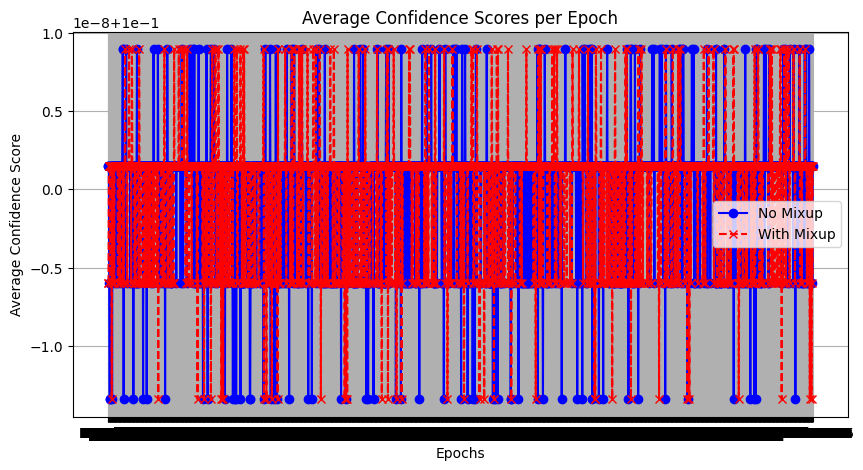

In [7]:
import matplotlib.pyplot as plt
import torch

# Assuming softmax_outputs_without_mixup and softmax_outputs_with_mixup are lists of tensors
# Calculate the average of outputs directly with PyTorch
average_without_mixup = [torch.mean(output.cpu()).item() for output in softmax_outputs_without_mixup]
average_with_mixup = [torch.mean(output.cpu()).item() for output in softmax_outputs_with_mixup]

# Plotting both datasets
plt.figure(figsize=(10, 5))
plt.plot(average_without_mixup, marker='o', linestyle='-', color='b', label='No Mixup')
plt.plot(average_with_mixup, marker='x', linestyle='--', color='r', label='With Mixup')
plt.title('Average Confidence Scores per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Confidence Score')
plt.xticks(range(len(average_without_mixup)), labels=[f'Epoch {i+1}' for i in range(len(average_without_mixup))])
plt.grid(True)
plt.legend()
plt.show()


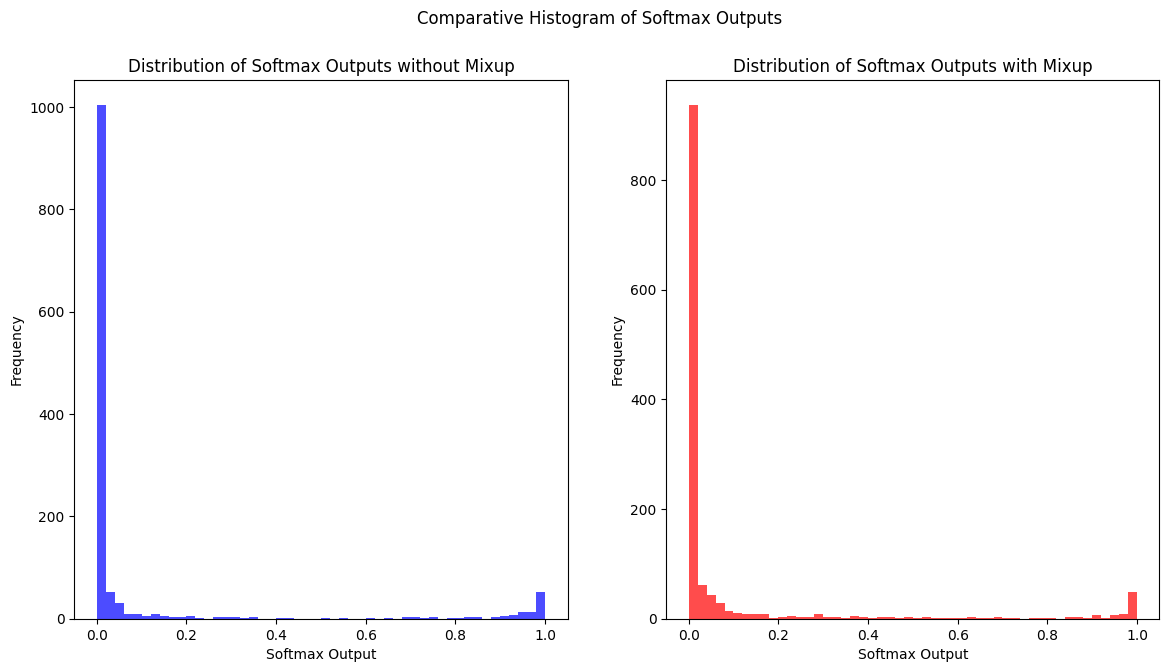

In [9]:


# Example of plotting raw softmax outputs for one batch
# Let's assume softmax_outputs_without_mixup and softmax_outputs_with_mixup contain outputs for multiple batches

# Convert a single batch's outputs to CPU and make them into a list of floats for plotting
outputs_no_mixup = softmax_outputs_without_mixup[0].cpu().numpy().flatten()
outputs_with_mixup = softmax_outputs_with_mixup[0].cpu().numpy().flatten()

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(outputs_no_mixup, bins=50, color='blue', label='No Mixup', alpha=0.7)
plt.title('Distribution of Softmax Outputs without Mixup')
plt.xlabel('Softmax Output')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(outputs_with_mixup, bins=50, color='red', label='With Mixup', alpha=0.7)
plt.title('Distribution of Softmax Outputs with Mixup')
plt.xlabel('Softmax Output')
plt.ylabel('Frequency')

plt.suptitle('Comparative Histogram of Softmax Outputs')
plt.show()


In [ ]:
print(softmax_outputs_without_mixup)

[tensor([[3.1671e-04, 2.9422e-04, 2.4018e-02,  ..., 2.6382e-01, 5.6097e-05,
         4.7025e-04],
        [8.0293e-04, 2.5539e-07, 9.9904e-01,  ..., 7.7343e-06, 1.3338e-06,
         3.6111e-07],
        [2.3486e-03, 1.7439e-04, 6.9750e-01,  ..., 1.3015e-01, 2.4749e-04,
         1.3565e-04],
        ...,
        [5.6765e-02, 1.0114e-01, 2.7861e-01,  ..., 8.6445e-04, 4.2903e-01,
         6.5039e-03],
        [9.9376e-01, 2.8067e-04, 1.5226e-03,  ..., 5.0240e-05, 3.4482e-04,
         3.7485e-03],
        [6.5464e-03, 1.3450e-04, 9.1023e-01,  ..., 1.3139e-02, 6.4123e-04,
         3.4999e-04]], device='cuda:0'), tensor([[5.3912e-05, 9.9809e-01, 1.1426e-05,  ..., 6.3614e-06, 3.2363e-05,
         1.7684e-03],
        [1.7386e-02, 2.1773e-02, 1.4099e-04,  ..., 2.0906e-04, 5.7808e-01,
         3.8122e-01],
        [1.6736e-04, 3.7089e-03, 2.7727e-03,  ..., 1.6664e-04, 1.7807e-04,
         1.0320e-02],
        ...,
        [2.2817e-03, 1.4700e-04, 1.1590e-03,  ..., 1.8374e-03, 4.8536e-03,
      